In [1]:
# requirements.txt
# pip install wget
# pip install keras
# pip install tensorflow
# pip install matplotlib
# pip install split-folders
# pip install sklearn

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import CSVLogger
from tensorflow.keras import layers

from tensorflow import keras

import matplotlib.pyplot as plt
import splitfolders
import itertools
import numpy as np

## 0 - Data Acquisition and Pre-Processing

#### Download and unzip dataset

In [4]:
# import wget
# url = 'https://data.mendeley.com/api/datasets-v2/datasets/bycbh73438/zip/download?version=1'
# wget.download(url)

#### Split data in train, val and test folders

In [5]:
# splitfolders.ratio(
#     "dataset_original", 
#     output="dataset_splitted",
#     seed=42, 
#     ratio=(.7, .1, .2),
#     group_prefix=None,
#     move=False)

In [6]:
ls dataset_splitted

 O volume na unidade C nÆo tem nome.
 O N£mero de S‚rie do Volume ‚ 8044-66AB

 Pasta de C:\Users\2160005316\Downloads\TCC\An-Intelligent-Lightweight-Drone-Monitoring-Solution-for-Insect-Damaged-Soybean-Crops\dataset_splitted

01/03/2022  17:08    <DIR>          .
01/03/2022  17:08    <DIR>          ..
01/03/2022  17:09    <DIR>          test
01/03/2022  17:09    <DIR>          train
01/03/2022  17:09    <DIR>          val
               0 arquivo(s)              0 bytes
               5 pasta(s)   122.543.865.856 bytes dispon¡veis


#### Create keras data generators

In [7]:
# setups

train_data_dir = 'dataset_splitted/train'
test_data_dir = 'dataset_splitted/test'
val_data_dir = 'dataset_splitted/val'

img_height = 500
img_width = 500
im_shape = (img_height,img_width)

batch_size = 32

seed = 42

data_generator = ImageDataGenerator()

# keras generator for train data
train_generator = data_generator.flow_from_directory(
    train_data_dir, 
    target_size=im_shape, 
    shuffle=True,
    seed=seed,
    class_mode='categorical', 
    batch_size=batch_size)

# keras generator for validation data
validation_generator = data_generator.flow_from_directory(
    val_data_dir, 
    target_size=im_shape, 
    shuffle=False,
    seed=seed,
    class_mode='categorical', 
    batch_size=batch_size)

# keras generator for test data
test_generator = data_generator.flow_from_directory(
    test_data_dir, 
    target_size=im_shape, 
    shuffle=False,
    seed=seed,
    class_mode='categorical',
    batch_size=batch_size)

number_train_samples = train_generator.samples
number_validation_samples = validation_generator.samples
number_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
num_classes  = len(classes)

Found 4486 images belonging to 3 classes.
Found 639 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


## 1 - Exploratory Analysis

#### Some dataset samples

In [32]:
def get_class_name(vector):
    class_key = list(vector).index(1)
    return {0:'Caterpillar', 
            1:'Diabrotica speciosa',
            2:'Healthy'}[class_key]

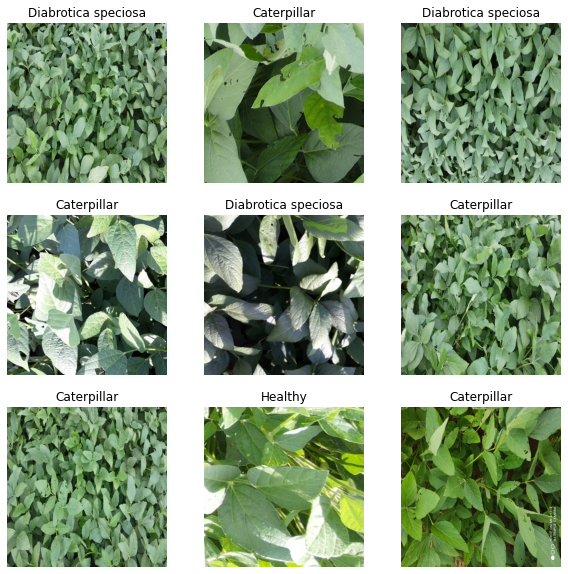

In [33]:
plt.figure(figsize=(10,10))

batch_example = train_generator.next()
images = batch_example[0]
labels = batch_example[1]

for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    
    image = images[i]
    label = get_class_name(labels[i])
    image = image.astype('uint8')
    plt.axis("off")
    plt.title(label)
    plt.imshow(image)
plt.show()

## 2 - Tranining and Evaluation

### 2.1 -  Model 1 Training and Evaluation

#### Create model setup

In [36]:
""""
MODELO QUALQUER SÓ PRA ORGANIZAR O NOTEBOOK
""""

inputs = keras.Input(shape=im_shape+(3,))
# Image augmentation block
# x = data_augmentation(inputs)
x = inputs

# Entry block
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # x = layers.Activation("relu")(x)
    # x = layers.SeparableConv2D(size, 3, padding="same")(x)
    # x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
activation = "softmax"
units = 3

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)

model = keras.Model(inputs, outputs)

""""
MODELO QUALQUER SÓ PRA ORGANIZAR O NOTEBOOK
""""

#### Training

In [54]:
epochs = 2

# set metrics
model.compile(
    optimizer = Adam(), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy'])

csv_logger = CSVLogger('log.csv', append=True, separator=';')

# saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1),
    csv_logger
]

# training
history = model.fit(
        train_generator,
        steps_per_epoch = number_train_samples // batch_size,
        epochs = epochs,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        verbose = 0,
        validation_steps = number_validation_samples // batch_size)


Epoch 1: val_loss improved from inf to 2.30295, saving model to model.h5

Epoch 2: val_loss improved from 2.30295 to 1.21639, saving model to model.h5


#### Show metrics

In [53]:
model = load_model('model.h5')

score = model.evaluate(validation_generator, verbose=0)
print('Val loss:', round(score[0],5))
print('Val accuracy:', round(score[1],5))

print('-'*25)
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', round(score[0],5))
print('Test accuracy:', round(score[1],5))

Val loss: 1.27316
Val accuracy: 0.13928
-------------------------
Test loss: 1.27295
Test accuracy: 0.14008


#### Predictions

In [46]:
y_generator_pred = model.predict(test_generator)
y_pred = np.argmax(y_generator_pred, axis=1)
target_names = classes

#### Reports

In [49]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

        Caterpillar       0.00      0.00      0.00       663
Diabrotica speciosa       0.00      0.00      0.00       442
            Healthy       0.14      1.00      0.25       180

           accuracy                           0.14      1285
          macro avg       0.05      0.33      0.08      1285
       weighted avg       0.02      0.14      0.03      1285



C:\Users\2160005316\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\2160005316\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\2160005316\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

#### Confusion matrix

In [51]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

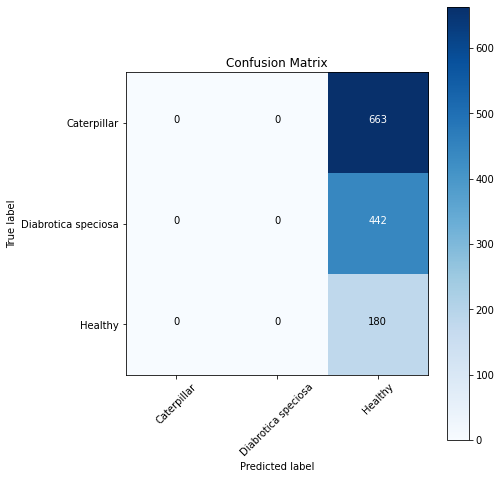

In [52]:
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

### 2.2 -  Model 1 Training and Evaluation

## 3 - Results Analysis